# "Fine-Tuning GPT-Neo for Text Classification and Generation"
***This project leverages a pretrained language model, GPT-Neo, to perform text-based tasks such as classification or generation. The workflow involves preprocessing a dataset with tokenization, training the model with PyTorch and Hugging Face's Transformers library, and evaluating its performance using metrics like accuracy. Key functionalities include fine-tuning the model on custom datasets, optimizing hyperparameters, and generating predictions. The project integrates modern machine learning techniques and tools to streamline model training, evaluation, and deployment.***

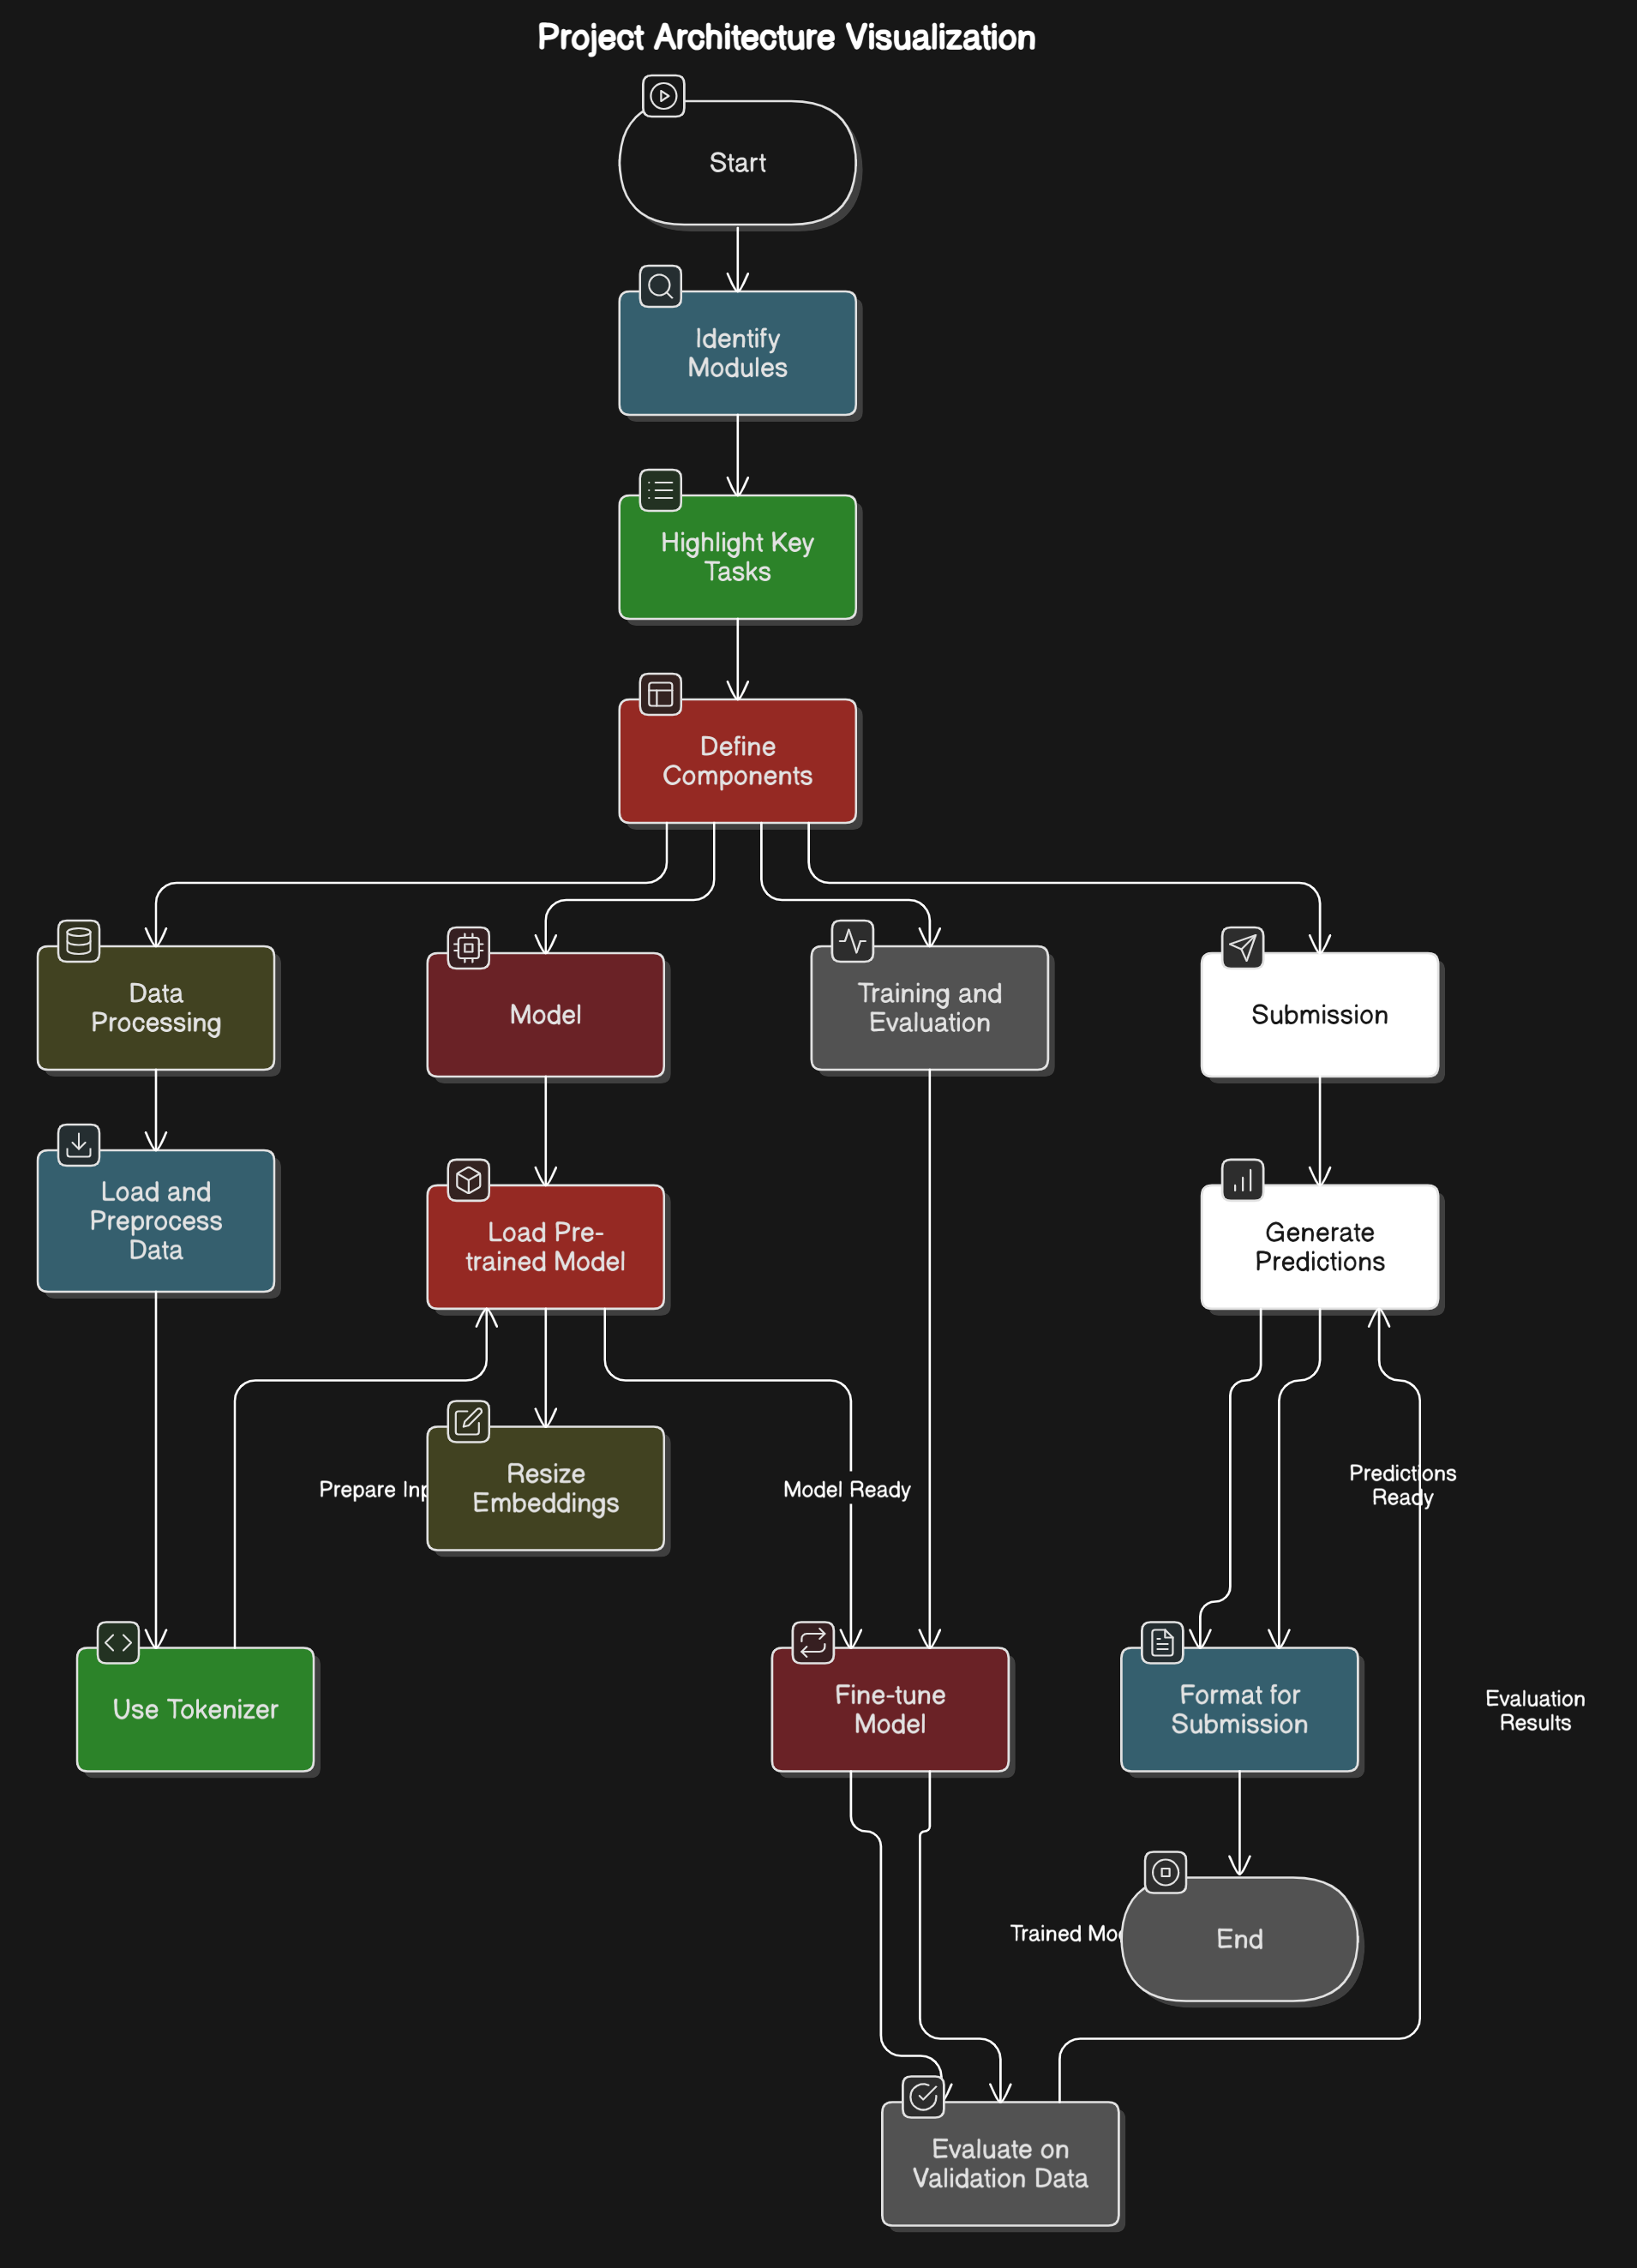
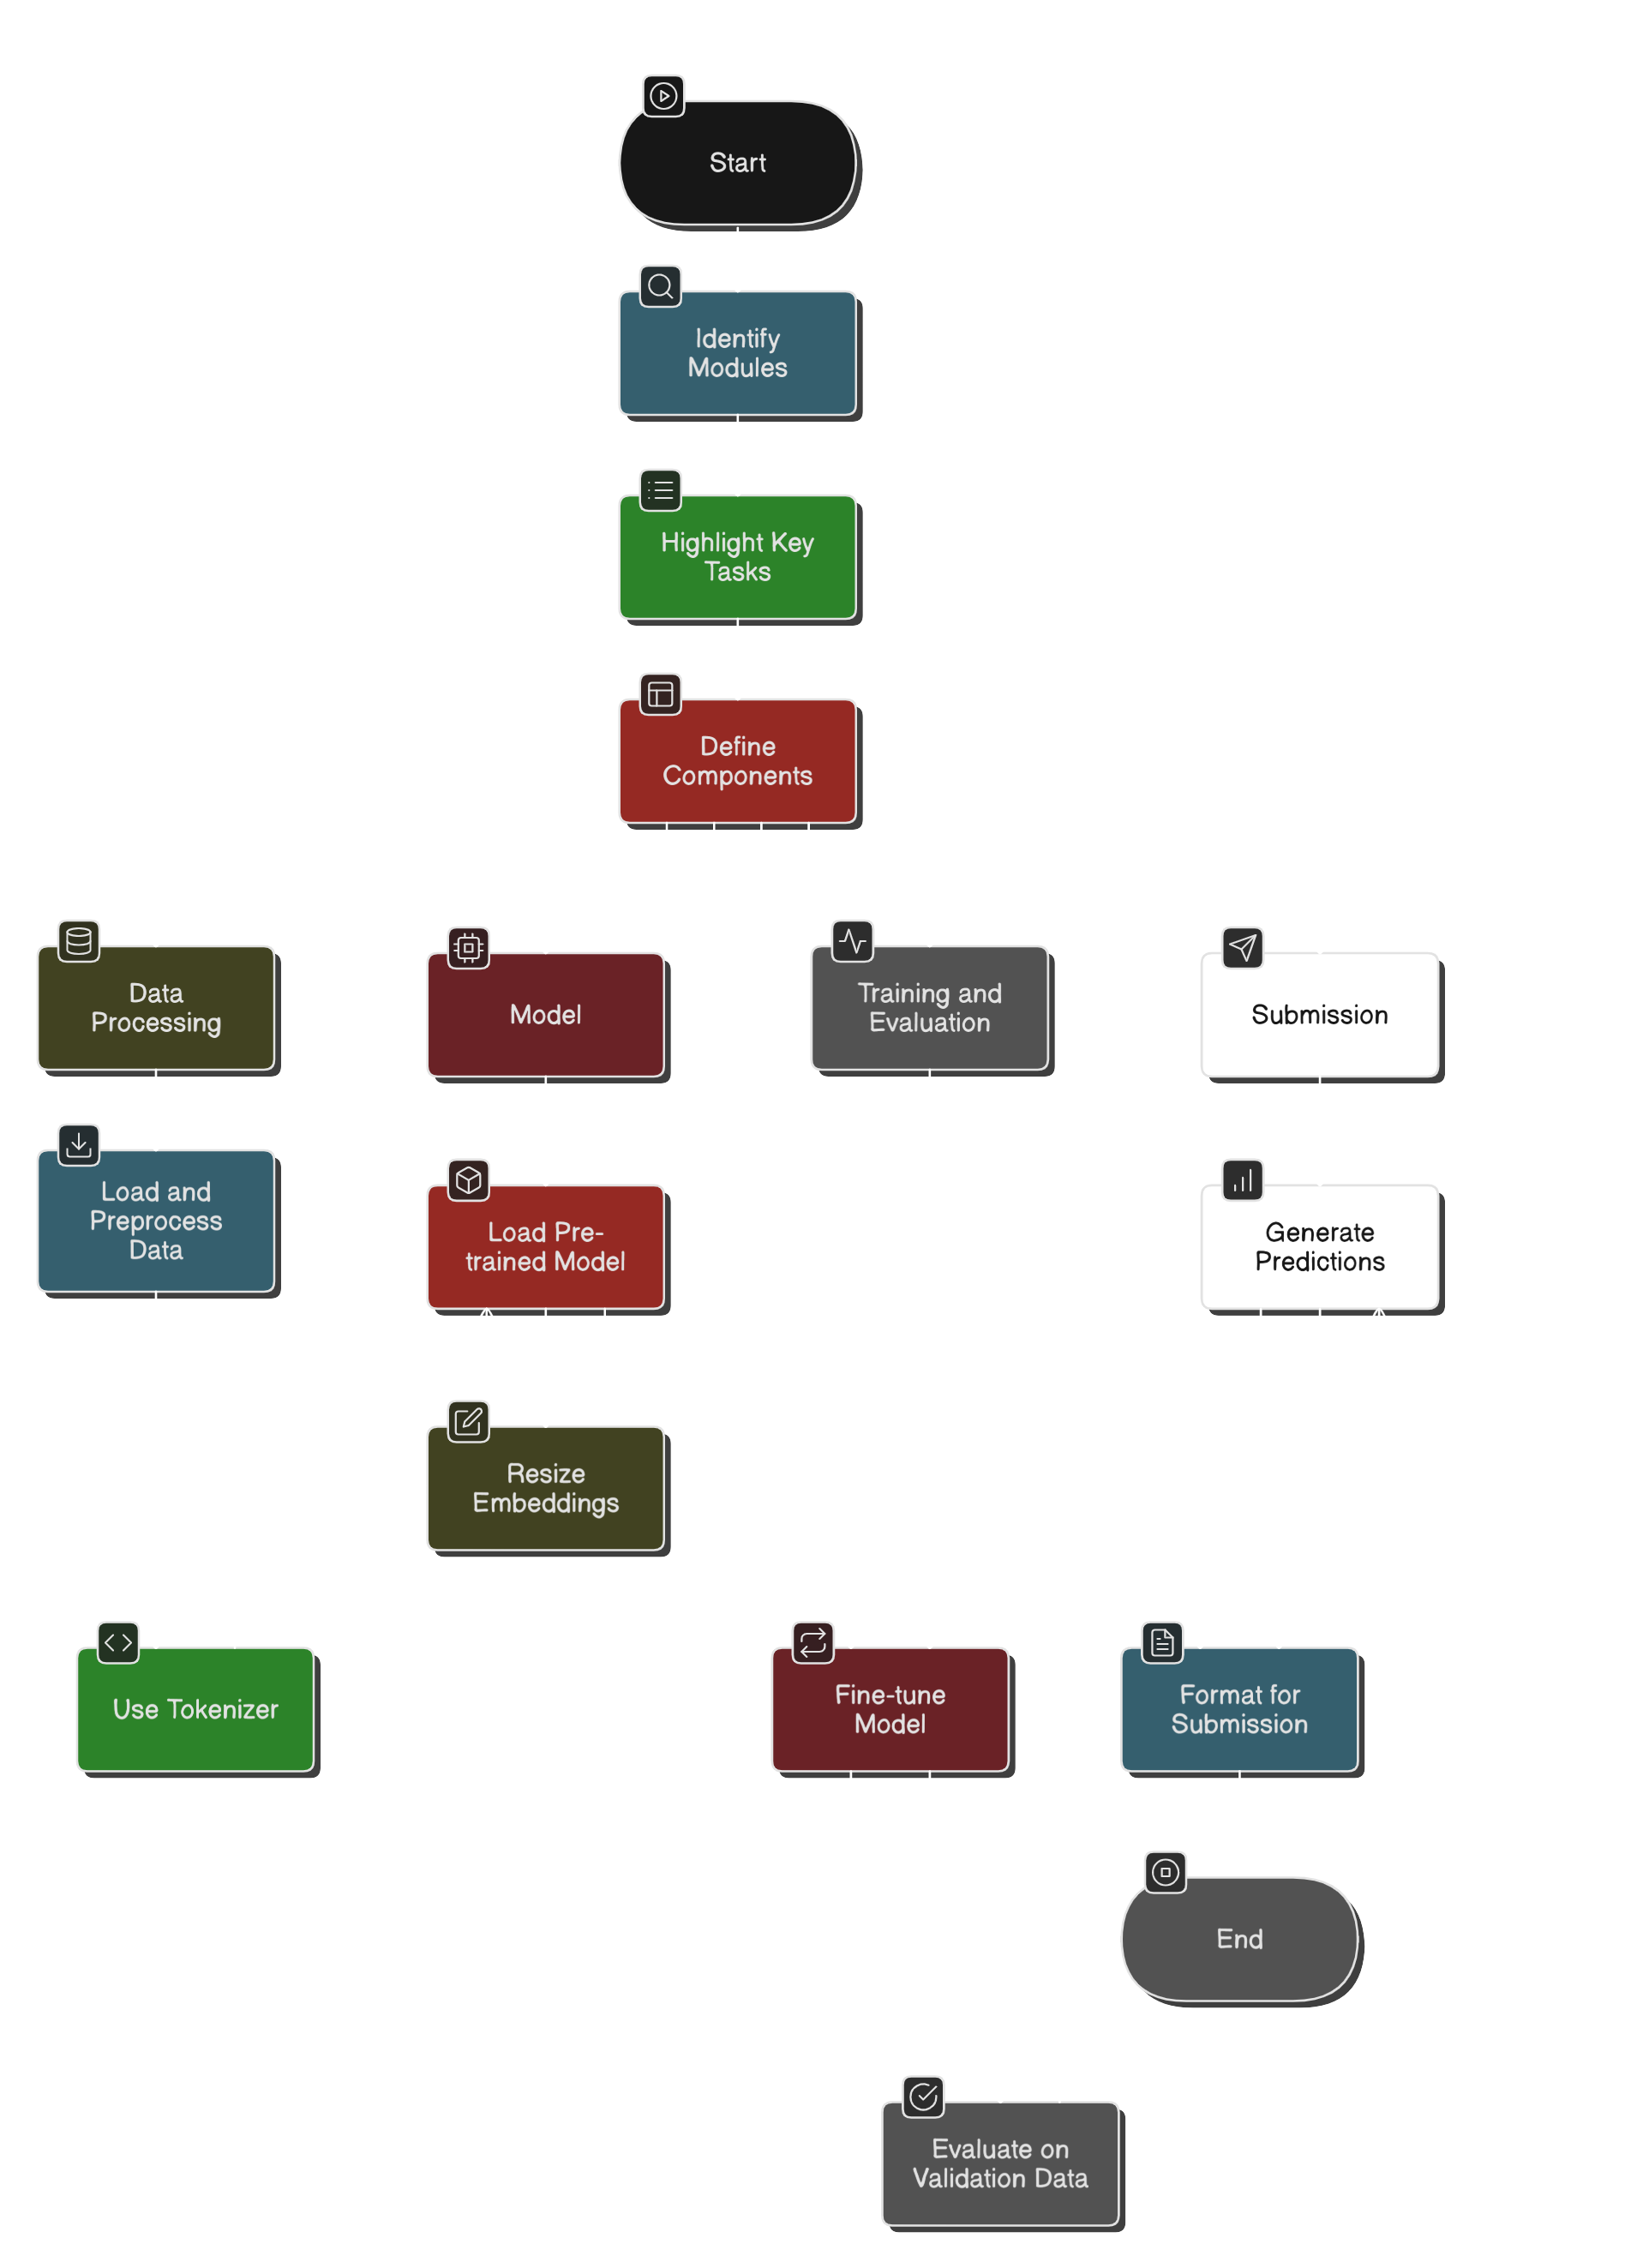

In [1]:
!pip install language-tool-python

In [2]:
!pip install transformers datasets bitsandbytes accelerate sentencepiece language-tool-python evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 25.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


In [3]:
import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
from IPython.display import display, HTML
import requests

## Data loading 

In [4]:
# Read train.csv and test.csv
print("Loading data...")
train_df = pd.read_csv("/kaggle/input/juridia-hackhaton-fine-tuning-llm-v/train.csv")
test_df = pd.read_csv("/kaggle/input/juridia-hackhaton-fine-tuning-llm-v/test.csv")

# Display first few rows of the train and test dataframes
print("\nTrain Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("\nTrain Data Sample:")
display(train_df.head())
print("\nTest Data Sample:")
display(test_df.head())

Loading data...

Train Data Shape: (5000, 5)
Test Data Shape: (500, 1)

Train Data Sample:


,file_name,long_title,date,doc_type,Id
0,8293.html,Décret n° 2-04-534 du 16 kaada 1425 (29 décemb...,2004-12-29,Décret,0d5401c3-6d59-4a9f-bbe8-4313b599e94b
1,9003.html,Décret n° 2-72-513 du 3 rebia I 1393 (7 avril ...,1973-04-07,Décret,fea3e4a6-7535-425f-bdf2-b792f6052cd5
2,11506.html,Dahir n° 1-03-300 du 2 rabii I 1425 (22 avril ...,2004-04-22,Dahir,b67a1c82-9fc7-4a4b-8c67-10f45f5b9dd2
3,22837.html,Arrêté du ministre de l’économie et des financ...,2019-05-30,Arrêté,7bace715-97c7-47d5-a321-d17e1bee26a8
4,7066.html,Dahir n° 1-17-15 du 28 ramadan 1438 (23 juin 2...,2017-06-23,Dahir,5590ac6b-aa88-4b0d-af35-633fbbeb0bbf



Test Data Sample:


,question
0,Quels sont les critères d'éligibilité à la ret...
1,Quelle est la durée maximale d'un contrat de t...
2,Quelle est la définition légale d'une donation ?
3,Comment fonctionne la médiation dans un litige...
4,Quelles sont les étapes d'une procédure de div...


# I- Data Preparation

### Azure Data Loading Function

In [5]:
def read_html_file_from_azure(file_name):
    # Azure Blob Storage details
    base_url = "https://juridiahackhaton.blob.core.windows.net/fine-tuning"
    sas_token = "?sp=r&st=2024-12-18T14:00:31Z&se=2024-12-23T22:00:31Z&skoid=84f95543-1f4f-468b-88b0-7ba29b72fff8&sktid=75319ac2-1960-4be6-b7bf-49f186bd8d73&skt=2024-12-18T14:00:31Z&ske=2024-12-23T22:00:31Z&sks=b&skv=2022-11-02&spr=https&sv=2022-11-02&sr=c&sig=G1chY5U9%2BocqupQtO%2FPZ0i4V4hxWUUD%2B09tYqZUAw2M%3D"
    file_name = "documents/" + file_name
    # Construct the complete blob URL with SAS token
    blob_url = f"{base_url}/{file_name}{sas_token}"

    # Fetch the HTML file
    response = requests.get(blob_url)

    if response.status_code == 200:
        # Display the HTML file content
        html_content = response.text
        return html_content
    else:
        print(f"Failed to fetch the HTML file: HTTP {response.status_code}")
        print(f"Error details: {response.text}")
        return False

# Example usage
html_content = read_html_file_from_azure("10361.html")
# def read_html_file_from_azure(file_name):
#     """Read HTML file from Azure Blob Storage"""
#     base_url = "https://juridiahackhaton.blob.core.windows.net/fine-tuning"
#     sas_token = "?sp=r&st=2024-12-18T14:00:31Z&se=2024-12-23T22:00:31Z&skoid=84f95543-1f4f-468b-88b0-7ba29b72fff8&sktid=75319ac2-1960-4be6-b7bf-49f186bd8d73&skt=2024-12-18T14:00:31Z&ske=2024-12-23T22:00:31Z&sks=b&skv=2022-11-02&spr=https&sv=2022-11-02&sr=c&sig=G1chY5U9%2BocqupQtO%2FPZ0i4V4hxWUUD%2B09tYqZUAw2M%3D"
#     file_name = "documents/" + file_name
#     blob_url = f"{base_url}/{file_name}{sas_token}"
    
#     try:
#         response = requests.get(blob_url)
#         if response.status_code == 200:
#             return response.text
#         print(f"Failed to fetch the HTML file: HTTP {response.status_code}")
#         return None
#     except Exception as e:
#         print(f"Error: {e}")
#         return None


### Test HTML file Loading

In [6]:
print("Testing HTML file loading...")
sample_html = read_html_file_from_azure("10361.html")
if sample_html:
    print("Successfully loaded HTML file")
    display(HTML(sample_html))


Testing HTML file loading...
Successfully loaded HTML file


""
Bulletin officiel n° 4800 du 1er juin 2000
EDITION DE TRADUCTION OFFICIELLE
""
[1] Le directeur de l'académie est nommé conformément aux dispositions des textes législatifs et réglementaires en vigueur.
"Article 11bis. : (Ajouté par l'article premier du dahir n° 1-16-04 du 15 rabii II 1437 (26 janvier 2016) publié en langue arabe) Les fonctionnaires titulaires et stagiaires exerçant leur travail dans les administrations des académies régionales d'éducation et de formation existantes à la date visée à l'article 15 ci-après, sont mutés, sur demande exprimant leur désir, qu'ils soumettent dans un délai maximum de trois (3) mois, à l'administration des académies régionales d'éducation et de formation créées selon le découpage régionale en vigueur ou à leurs services provinciaux, ou aux établissements d'enseignement qui en dépendent. Toutefois, dans le cas où les personnes concernées ne présentent pas leur demande, elles sont automatiquement mutées aux besoins du service. Les services rendus par les intéressés, y compris la durée de travail dans les académies régionales d'éducation et de formation où ils travaillaient, sont considérés comme ayant été rendus à l'académie régionale d'éducation et de formation vers laquelle ils ont été mutés."
"Article 13 bis : (Ajouté par l'article premier du dahir n° 1-16-04 du 15 rabii II 1437 (26 janvier 2016) publié en langue arabe) Les académies régionales d'éducation et de formation créées selon le découpage régional en vigueur à la date de publication de la présente loi au Bulletin Officiel et dont les listes, sièges et compétence territoriale sont fixés par texte règlementaire, remplacent les académies régionales d'éducation et de formation existantes à ladite date, en tous droits et obligations, et ce selon les modalités fixées par texte règlementaire."
"Article 13 ter : (Ajouté par l'article premier du dahir n° 1-16-04 du 15 rabii II 1437 (26 janvier 2016) publié en langue arabe) Les biens, meubles et valeurs en possession des académies régionales d'éducation et de formation existants sont transférés à titre onéreux à la propriété des académies régionales d'éducation et de formation créées selon le découpage régional en vigueur, qui se substituent à elles en plein droit de leur propriété, et ce dans les limites de la compétence territoriale de chaque académie. Le transfert de propriété susvisé n'entraîne le paiement d'aucune redevance à l'Agence nationale de la conservation foncière, du cadastre et de la cartographie. Les modalités d'application des dispositions du présent article, chaque fois que cela est nécessaire, sont fixées par décret pris sur proposition des deux autorités gouvernementales chargées de l'éducation nationale et des finances."
Article 15 : (abrogé et remplacé par l'article 3 du dahir n° 1-16-04 du 15 rabii II 1437 (26 janvier 2016) publié en langue arabe La présente loi entre en vigueur à compter de sa date de sa publication au « Bulletin officiel«.


In [7]:
from bs4 import BeautifulSoup

def add_extracted_content_to_dataframe(df):
    """Add extracted visible content from HTML to DataFrame."""
    print("Adding extracted visible content to DataFrame...")
    
    def extract_visible_text(html):
        """Extract visible text from HTML."""
        if not html:
            return ""
        soup = BeautifulSoup(html, "html.parser")
        return soup.get_text(separator="\n").strip()
    
    # Extract and store visible content directly
    df['extracted_content'] = df['file_name'].apply(
        lambda file_name: extract_visible_text(read_html_file_from_azure(file_name))
    )
    
    return df

# Process training data
print("Processing training data...")
train_df = add_extracted_content_to_dataframe(train_df)

# Display processed data with visible content
print("\nProcessed Train Data Sample (with visible content):")
display(train_df.head())


Processing training data...
Adding extracted visible content to DataFrame...

Processed Train Data Sample (with visible content):


,file_name,long_title,date,doc_type,Id,extracted_content
0,8293.html,Décret n° 2-04-534 du 16 kaada 1425 (29 décemb...,2004-12-29,Décret,0d5401c3-6d59-4a9f-bbe8-4313b599e94b,Bulletin officiel n° 6570 du 18 mai 2017\n \n ...
1,9003.html,Décret n° 2-72-513 du 3 rebia I 1393 (7 avril ...,1973-04-07,Décret,fea3e4a6-7535-425f-bdf2-b792f6052cd5,Bulletin officiel n° 3155 du 7 avril 1973\n \n...
2,11506.html,Dahir n° 1-03-300 du 2 rabii I 1425 (22 avril ...,2004-04-22,Dahir,b67a1c82-9fc7-4a4b-8c67-10f45f5b9dd2,Bulletin officiel n° 5210 du 16 rabii I 1425 (...
3,22837.html,Arrêté du ministre de l’économie et des financ...,2019-05-30,Arrêté,7bace715-97c7-47d5-a321-d17e1bee26a8,Bulletin Officiel n° 6784 bis du 3 chaoual 144...
4,7066.html,Dahir n° 1-17-15 du 28 ramadan 1438 (23 juin 2...,2017-06-23,Dahir,5590ac6b-aa88-4b0d-af35-633fbbeb0bbf,Bulletin officiel n° 6662 du 5 avril 2018\n \n...


In [8]:
# display(HTML(train_df.html_content[0]))

In [10]:
# Set up the tokenizer with proper padding token
# tokenizer.pad_token = tokenizer.eos_token
# model.config.pad_token_id = tokenizer.pad_token_id

In [11]:
# Prepare the dataset for fine-tuning
from datasets import Dataset
from transformers import Trainer, TrainingArguments
from transformers import DataCollatorForLanguageModeling
import evaluate
import numpy as np
import time

# Prepare Unified Text Representation


In [29]:
from datasets import Dataset

# Combine text fields for training
def prepare_dataset(df):
    df['combined_text'] = df.apply(lambda x: f"""Title: {x['long_title']}
Type: {x['doc_type']}
Date: {x['date']}
Content: {x['extracted_content']}""", axis=1)
    return Dataset.from_pandas(df[['combined_text']])

train_dataset = prepare_dataset(train_df)


# Dataset Tokenization

In [31]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-1.3B")

# Add a padding token if it doesn't exist
if tokenizer.pad_token is None:
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

# Tokenization function
def tokenize_function(examples):
    return tokenizer(
        examples['combined_text'], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )

# Resize model embeddings to account for the new padding token if needed
# This step ensures the model can handle the new padding token if you train or fine-tune it later
# Only required if you're modifying an existing model
# model.resize_token_embeddings(len(tokenizer))

# Tokenize dataset
train_dataset = train_dataset.map(
    tokenize_function,
    batched=True,
    remove_columns=train_dataset.column_names
)


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

# Verifying the padding token

In [32]:
print("Padding token:", tokenizer.pad_token)
print("Padding token ID:", tokenizer.pad_token_id)


Padding token: [PAD]
Padding token ID: 50257


# Model and Training Setup

In [ ]:
from transformers import AutoModelForCausalLM, Trainer, TrainingArguments, DataCollatorForLanguageModeling

# Load model
model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-neo-1.3B")

# Define training arguments
training_args = TrainingArguments(
    output_dir="./juridia_model",
    num_train_epochs=3,
    per_device_train_batch_size=1,
    save_steps=50,
    evaluation_strategy="steps",
    eval_steps=50,
    logging_dir='./logs',
    logging_steps=10,
    learning_rate=2e-5,
    fp16=True,
    gradient_checkpointing=True
)

# Data collator
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator
)

# Train model
trainer.train()


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


# Evaluation

In [ ]:
# Evaluation Metrics
def evaluate_relevance(pred, ref):
    pred_words = set(pred.lower().split())
    ref_words = set(ref.lower().split())
    intersection = len(pred_words & ref_words)
    union = len(pred_words | ref_words)
    return intersection / union if union > 0 else 0.0

def evaluate_completeness(pred, ref):
    return min(len(pred.split()) / max(len(ref.split()), 1), 1.0)

def evaluate_legal_soundness(pred):
    legal_terms = {'loi', 'article', 'code', 'juridique'}
    return sum(1 for term in legal_terms if term in pred.lower())

# Load test data
test_dataset = prepare_dataset(test_df)

# Predict and evaluate
test_predictions = trainer.predict(test_dataset)
predictions = tokenizer.batch_decode(test_predictions.predictions, skip_special_tokens=True)

# Evaluate metrics
test_df['predictions'] = predictions
test_df['relevance'] = test_df.apply(lambda x: evaluate_relevance(x['predictions'], x['combined_text']), axis=1)
test_df['completeness'] = test_df.apply(lambda x: evaluate_completeness(x['predictions'], x['combined_text']), axis=1)
test_df['legal_soundness'] = test_df['predictions'].apply(evaluate_legal_soundness)

print("Evaluation Complete")
display(test_df[['predictions', 'relevance', 'completeness', 'legal_soundness']].head())


# Submission

In [ ]:
# Prepare the submission DataFrame
submission_df = test_df[['id', 'predictions']].copy()
submission_df.rename(columns={'predictions': 'extracted_content'}, inplace=True)

# Save to a CSV file
submission_file_path = "submission.csv"
submission_df.to_csv(submission_file_path, index=False)

# Verify the submission format
print("Submission File Saved!")
print(submission_df.head())


In [ ]:
# Print submission statistics
print("\nSubmission Statistics:")
print(submission_df.describe())

In [ ]:
# Verify submission format
print("\nVerifying submission format...")
required_columns = ['Id', 'relevance', 'completeness', 'legal_soundness', 'fluency', 'latency']
missing_columns = [col for col in required_columns if col not in submission_df.columns]

if missing_columns:
    print(f"Warning: Missing required columns: {missing_columns}")
else:
    print("All required columns present in submission file.")

print("\nSample predictions:")
print(submission_df.head())